<a href="https://colab.research.google.com/github/Orange314159/DataScience/blob/main/MattRobsU3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q "preliz[full,notebook]" ## use -q to reduce the included text for download

In [ ]:
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import arviz as az
import pymc as pm
import altair as alt

# Sleep Tracking (again)

## Context
In this project I will further discover the extent to the poor sleep of my subject. I will be using the same period of time as in project two where I measure the ammount of sleep of my subject, but in this case I will be using the exact sleep amount, rather than the black and white (>8hrs of sleep).

### A quick note on my priors:
Here are my predictions for the given moments of data:  
Mean: 7hrs  
Variance: 3hrs  
Skewness: small (0.1 ish)  
Kurtosis: medium (3 ish)  
Based on this and the information that I get from drawing the posterior I will be able to create my priors.

## Likelihood
I will use my data set that he has reported on his sleep. It appears that he has a fairly normally distributed sleep pattern with a slight right skew. Additionally, this looks to have a mean of about 7hrs.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<BarContainer object of 10 artists>


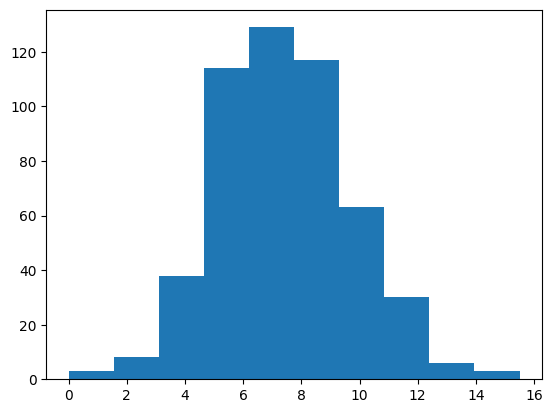

In [7]:
# Using Polars, import the sleep data (a table of 1s and 0s with width of 7)
sleepData = pl.read_csv("/content/drive/MyDrive/DataScience/UnitThreeProjectDataSet.csv")

## plot the data
print(plt.hist(sleepData.to_numpy().flatten())[2])

data = sleepData.to_numpy().flatten()


## Priors
For my prior I belive that my subject will have generally normally distributed sleep with some outliers. This is beacuse I think that he is not near any physical limit that would create a skew. I think there will be some outliers because I belive that may be nights where he had too much homework or a flight or something that could lead to 0hrs of sleep or possibly 10hrs of sleep if he is sick and spends a long time in bed. Additionally, there might be a slight right skew because of the strict physical limit at 0hrs of sleep, but I do not think that this will be significant.

For this reason I let my mean be decribed by right skewed prior

Axes(0.125,0.11;0.775x0.77)


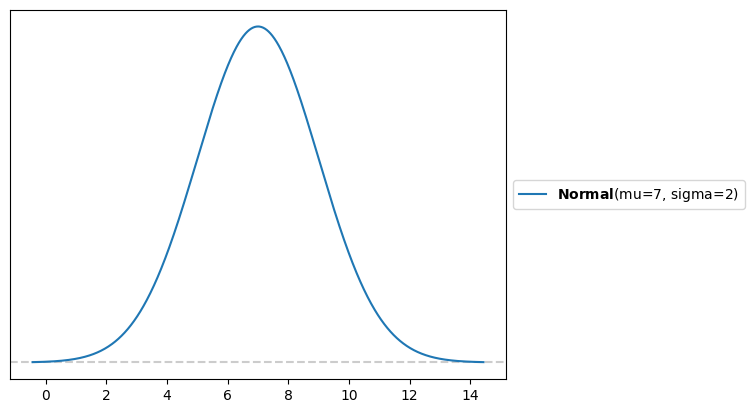

In [8]:
print(pz.Normal(7,2).plot_pdf())

I will use LogNormal for my stDev prior because a stDev can't be negative and the LogNormal distribution fits this requirement.

Axes(0.125,0.11;0.775x0.77)


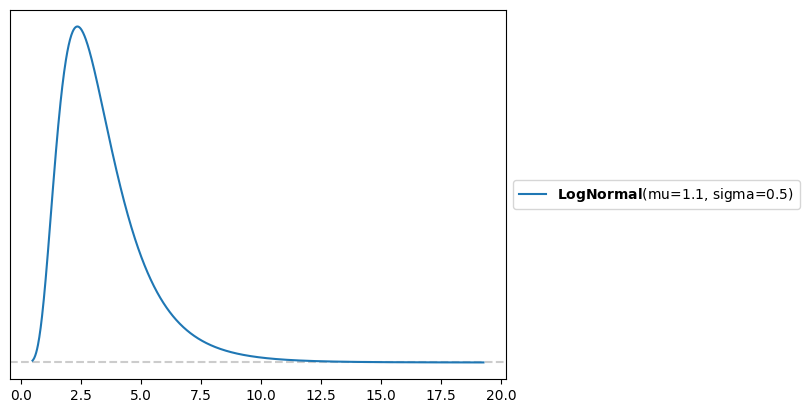

In [9]:
import math
print(pz.LogNormal(math.log(3), 0.5).plot_pdf())

This again looks fairly similar, but ever so slightly closer matching to my data, but more importantly it further matches my context because it keeps the projection of my subjects sleep above 0 more often, matching the physical limits I see in my context.

In [ ]:
with pm.Model() as model_sleep:
    prior = pm.Normal("mu", mu=7, sigma=2)
    prior2 = pm.LogNormal("sigma", mu=math.log(1), sigma=0.5)
    Y = pm.Normal('Y', mu = prior, sigma = prior2, observed=data)
    idata_sleep = pm.sample()

Axes(0.547727,0.11;0.352273x0.77)


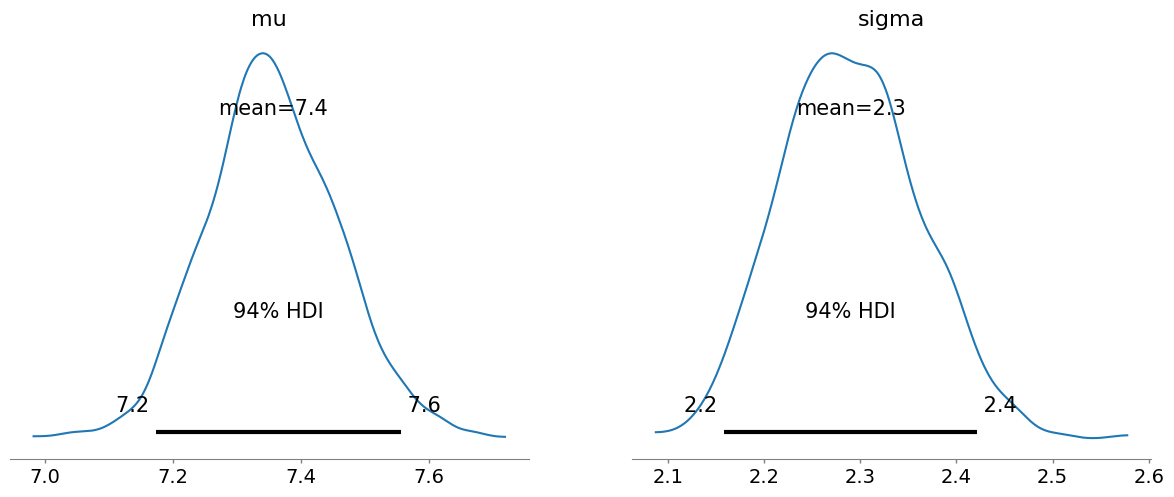

In [11]:
print(az.plot_posterior(idata_sleep)[1])

Output()

<Axes: xlabel='Y'>

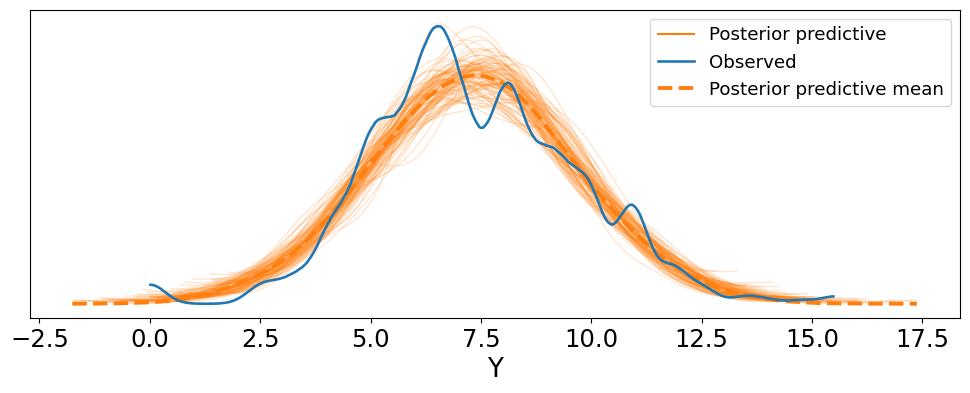

In [12]:
pm.sample_posterior_predictive(idata_sleep, model=model_sleep, extend_inferencedata=True)
az.plot_ppc(idata_sleep, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

The above model looks pretty good, but I think we can do better. The main drawback that I currently observe is a right skew that I predicted might be possible. Based on this, I am going to try the same normal distribution but with a skew.

In [ ]:
with pm.Model() as model_sleep2:
    prior = pm.Normal("mu", mu=7, sigma=2)
    prior2 = pm.LogNormal("sigma", mu=math.log(1), sigma=0.5)
    prior3 = pm.Normal("skew", mu=0.5, sigma=0.25)
    Y = pm.SkewNormal('Y', mu = prior, sigma = prior2, alpha = prior3 ,observed=data)
    idata_sleep = pm.sample()

Axes(0.398529,0.11;0.227941x0.77)


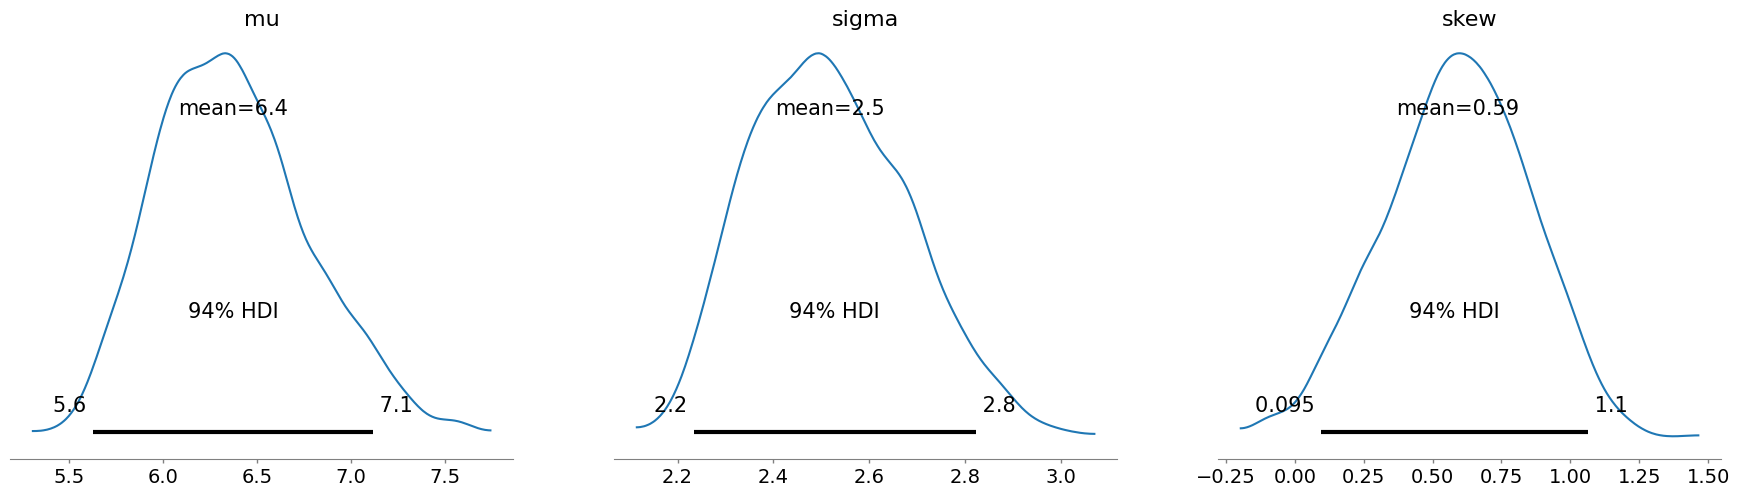

In [14]:
print(az.plot_posterior(idata_sleep)[1])

Output()

<Axes: xlabel='Y'>

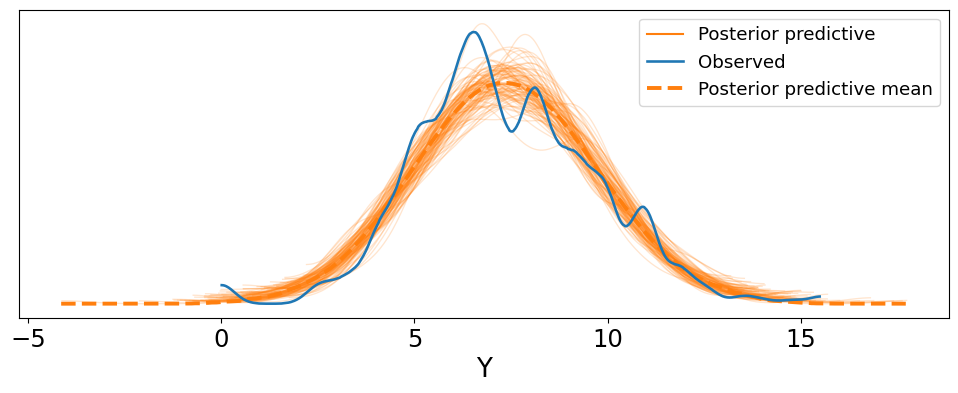

In [15]:
pm.sample_posterior_predictive(idata_sleep, model=model_sleep2, extend_inferencedata=True)
az.plot_ppc(idata_sleep, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

In [16]:
posterior_predictive_mean = idata_sleep.posterior_predictive["Y"].mean()
print("mean:", "\t\t", round(posterior_predictive_mean.mean().item(),3))

hda_95 = az.hdi(idata_sleep.posterior_predictive["Y"], hdi_prob=0.95)
print("95% HDA:", "\t", (hda_95.Y.min().item(), hda_95.Y.max().item()))

hda_68 = az.hdi(idata_sleep.posterior_predictive["Y"], hdi_prob=0.6827)
print("68.27% HDA:", "\t", (hda_68.Y.min().item(), hda_68.Y.max().item()))

mean: 		 7.356
95% HDA: 	 (2.045562695260755, 12.760538115661383)
68.27% HDA: 	 (4.415870532088683, 10.172962501807191)


## Conclusion

Based on my final model, it appears that my subject is projected to sleep approximately normal distribution centered about 7.36hrs of sleep. The model also suggests that we will find the subjects sleep to fall between 2.298hrs and 12.564hrs 95% of the time. This supports my earlier guess that the distribution might be slightly right skewed as this range includes more to right of the mean. Looking at our "one sigma" we find that it extends 2.979hrs to the left and 2.730hrs to the right, suggesting that my original guess of 3 as the standard deviation was very close. My guess of 7 for a mean was somewhat close, but it was a little low which probably could have been corrected for by considering the time that the subject was not in school (on summer break).